# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [ ]:
# TODO: load your data
# df = pd.read_csv('path/to.csv', parse_dates=['Date'], index_col='Date')

## Option B: Synthetic Generator (Use if you don't have data ready)

In [2]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [4]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['momentum_10'] = df['ret'].rolling(10).sum().shift(1)
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)

# Add your own:
# df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,y_next_ret,y_up,momentum_10,roll_vol_20
2021-01-29,100.198878,0.016949,0.016807,-0.014854,-0.003707,0.001845,1,-0.024953,0.007370
2021-02-01,100.383751,0.001845,0.001843,0.016949,0.002509,-0.003565,0,-0.002068,0.008455
2021-02-02,100.025880,-0.003565,-0.003571,0.001845,0.001706,0.020804,1,0.001192,0.008429
2021-02-03,102.106835,0.020804,0.020591,-0.003565,0.000685,-0.000154,0,-0.007740,0.008453
2021-02-04,102.091126,-0.000154,-0.000154,0.020804,0.004236,-0.014106,0,0.015375,0.009675


## Split

In [5]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

In [7]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)

mse = mean_squared_error(y_te_reg, pred)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

RMSE: 0.014484996137727905


              precision    recall  f1-score   support

           0       0.58      0.77      0.66        53
           1       0.52      0.30      0.38        43

    accuracy                           0.56        96
   macro avg       0.55      0.54      0.52        96
weighted avg       0.55      0.56      0.54        96



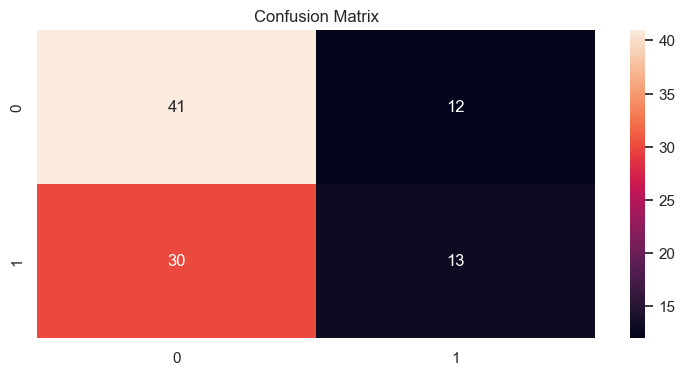

In [8]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation

- **What worked?**  
  The models successfully used lag and rolling features to capture some temporal structure in returns.  
  For forecasting, the regression achieved an RMSE of about 0.0145, which indicates moderate predictive accuracy given the noisy nature of financial returns.  
  For classification, the model correctly identified a fair number of down moves (41 true negatives), showing some ability to detect direction.

- **Where might assumptions fail?**  
  Both models assume stable relationships over time, but financial returns are often non-stationary, with changing volatility and structural breaks.  
  The classification model struggles with imbalance between up and down predictions (many false negatives), which suggests the linear decision boundary may not capture complex market dynamics.  
  The regression residuals may still exhibit heteroskedasticity and autocorrelation, violating standard regression assumptions.

- **How would you extend features or model?**  
  I would try adding richer features such as rolling volatility, momentum indicators, or z-scores.  
  For classification, I could address imbalance with resampling or adjusted thresholds.  
  For forecasting, more flexible models (e.g., tree-based models, regularized regression, or recurrent neural networks) could be explored.  
  Cross-validation with proper time splits would also improve robustness of evaluation.


### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.